# WSI - ćwiczenie 5 - Sztuczne sieci neuronowe
*Tomasz Żebrowski, Tomasz Frankowski*

Celem zadania była implementacja perceptronu wielowarstwowego oraz odpowiedniego algorytmu służąceg odo optymalizacji jego wag. Nasza implementacja znajduje się w pliku `mpl.py`. Najważniejszym jego elementem jest klasa `MLP` realizująca oba zadania. Posiada ona m.in. metody `predict` i `fit`. Pierwsza realizuje wyznaczanie wyjść perceptronu dla zadanych wejść, druga natomiast realizuje uczenie sieci z wykorzystaniem algorytmu optymalizacji gradientowej. Dodatkowo, w pliku tym zaimplementowane są funkcje aktywacji neuronu oraz ich pochodne.

Pracę, zgodnie ze wskazówką, rozpoczynamy od weryfikacji poprawności działania zaimplementowanych elementów na zadaniu XOR.

In [25]:
import numpy as np
from mlp import MLP, elu, d_elu_dt
# Definicja zadania xor
X_xor_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor_train = np.array([[0], [1], [1], [0]])
# Zaproponowana struktura sieci - 3 neurony w jednej warstwie ukrytej
mlp = MLP(2, 3, 1, 1, elu, d_elu_dt)
mlp.fit(X_xor_train, y_xor_train, 2137, 0.1)
y_xor_pred = mlp.predict(X_xor_train)
for i, x in enumerate(X_xor_train):
    print(x,"-> ", "%.1f" % y_xor_pred[i][0])

[0 0] ->  0.0
[0 1] ->  1.0
[1 0] ->  1.0
[1 1] ->  0.0


Wynik jest obiecujący. Perceptron prawidłowo realizuje funkcję XOR. Dla zapewnienia sobie dodatkowej pewności, testujemy go na zadaniu aproksymacji funkcji kwadratowej.

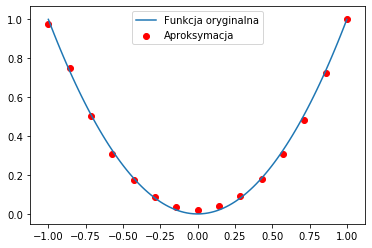

In [26]:
import matplotlib.pyplot as plt

X_square_train = np.linspace(-1, 1, 100)
y_square_train = np.array([x**2 for x in X_square_train])
X_square_train = np.array([[x] for x in X_square_train])
y_square_train = np.array([[y] for y in y_square_train])

X_square_test = np.linspace(-1, 1, 15)
y_square_test = np.array([x**2 for x in X_square_test])
X_square_test = np.array([[x] for x in X_square_test])
y_square_test = np.array([[y] for y in y_square_test])

mlp = MLP(1, 3, 2, 1, elu, d_elu_dt)
mlp.fit(X_square_train, y_square_train, 1519, 0.1)
y_predict = mlp.predict(X_square_test)

plt.plot(X_square_train, y_square_train, label="Funkcja oryginalna")
plt.scatter(X_square_test, y_predict, color="red", label="Aproksymacja")
plt.legend()
plt.show()

Ponownie, obserwujemy poprawne działanie perceptronu. Możemy przejść do przygotowania danych z zadanego zbioru.

### Przygotowanie danych

Rozpoczynamy od pobrania zbioru danych. Wykorzystujemy do tego funkcję `load_wine`  z pakietu *scikit-learn*. Sprawdzamy liczbę klas i parametrów. Poniżej przedstawiamy wynik.

In [27]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target
class_names = data.target_names
feature_names = data.feature_names
print("Liczba parametrów:", len(feature_names))
print("Liczba klas:", len(class_names))

Liczba parametrów: 13
Liczba klas: 3


Dane dzielimy na podzbiory uczący i testowy w stosunku 4:1

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print("Liczność zbioru uczącego:", len(X_train))
print("Liczność zbioru testowego:", len(X_test))

Liczność zbioru uczącego: 142
Liczność zbioru testowego: 36


Konieczne jest odpowiednie przetworzenie danych. Elementy zbioru y są liczbami odpowiadającymi numerowi klasy, natomiast nam zależy na szeregu liczb odpowiadającym przynależności do każdej z klas (Ponieważ takie wyjścia będzie miał perceptron). Dodatkowo, wszystkie parametry skalujemy tak, by ich odchylenie standardowe było równe 1, a średnia 0. Wpłynie to pozytywnie na wyniki eksperytmentów.

In [29]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Tak przygotowane dane podajemy do perceptronu (o założonej z góry, dość losowej strukturze) i sprawdzamy co z tego wyjdzie.

In [92]:
mlp = MLP(13, 13, 2, 3, elu, d_elu_dt)
mlp.fit(X_train, y_train, 100, 0.001)

In [93]:
from mlp import accuracy
y_pred = mlp.predict(y_train)
acc = accuracy(np.argmax(y_train, axis=1), np.argmax(y_pred, axis=1))
print(acc)

0.7112676056338029
[0.6755580454274193, 0.4228149350399041, 0.1908805660491356]
